In [7]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))

    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        # For simplicity, using midpoint ODE solver in this example
        return x_t + (t_end - t_start) * self(x_t + self(x_t, t_start) * (t_end - t_start) / 2,
        t_start + (t_end - t_start) / 2)

# training
flow = Flow()
optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()
from tqdm import  tqdm
for _ in tqdm(range(20000)):
    x_1 = Tensor(make_moons(256, noise=0.05)[0])
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    optimizer.zero_grad()
    loss_fn(flow(x_t, t), dx_t).backward()
    optimizer.step()

# sampling

100%|██████████| 20000/20000 [01:14<00:00, 270.20it/s]


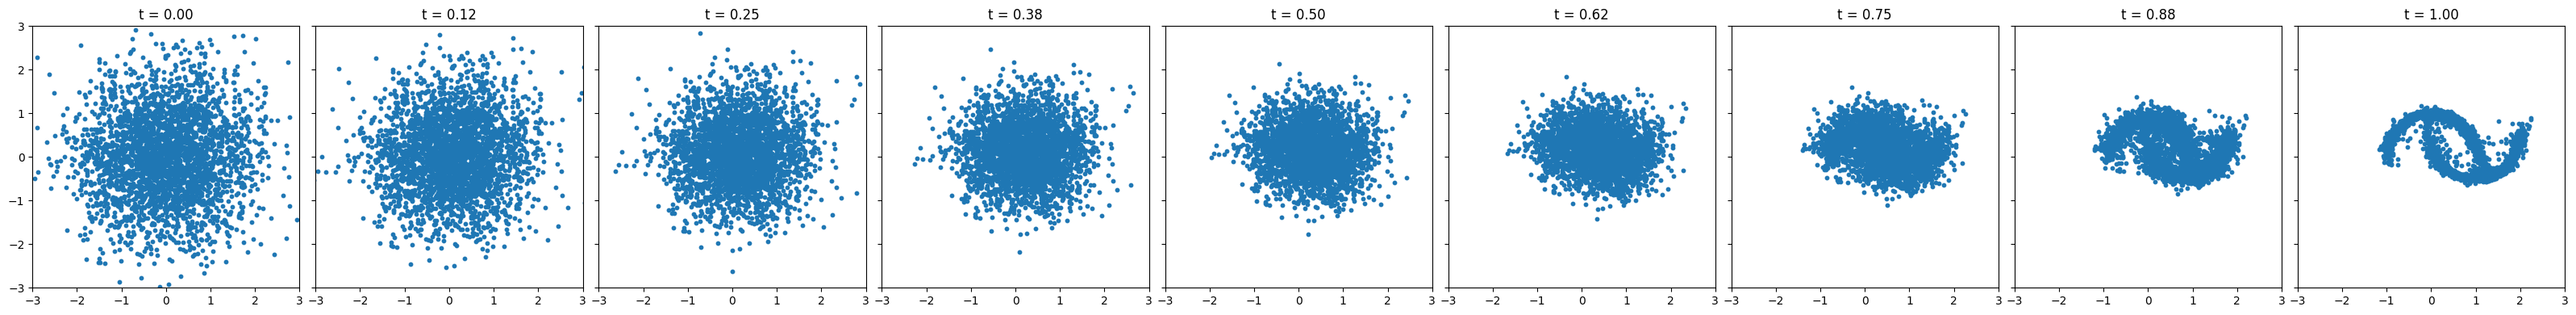

In [10]:
x = torch.randn(3000, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(32, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x, time_steps[i], time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

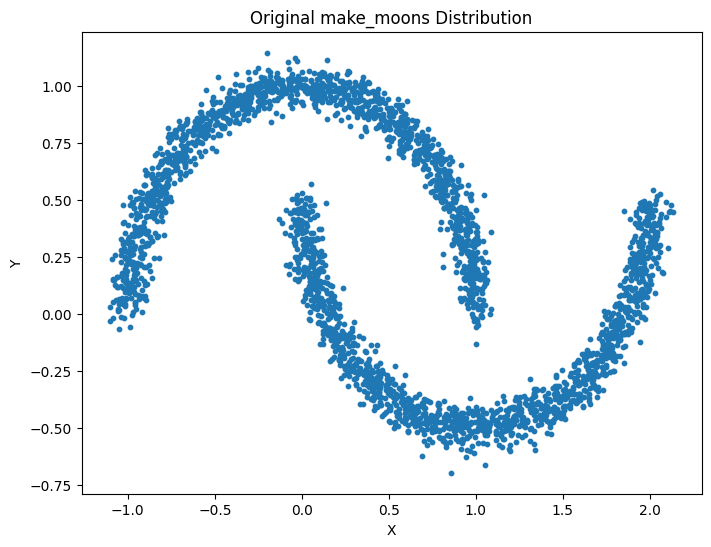

In [13]:
# Visualize the make_moons distribution
plt.figure(figsize=(8, 6))
X, _ = make_moons(n_samples=3000, noise=0.05)
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title('Original make_moons Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(False)
plt.show()

# flow and velocity field

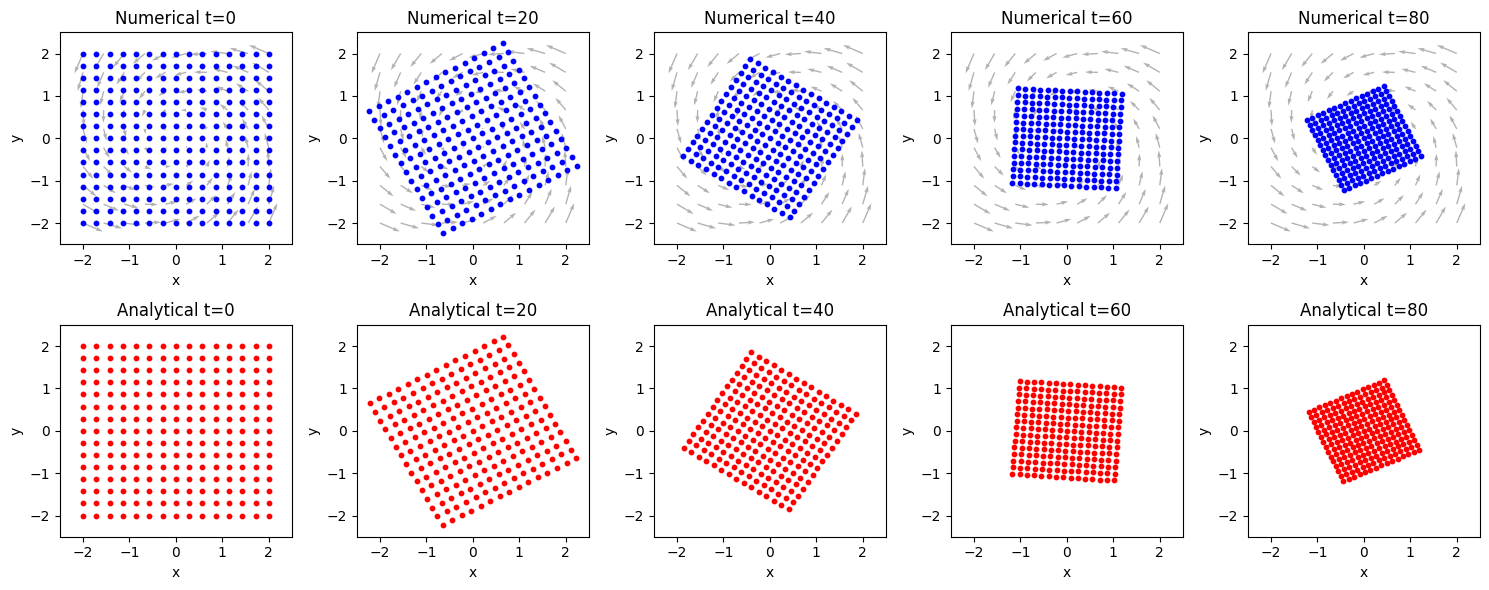

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define time-dependent velocity field
# This function returns the velocity components u, v at a given position (x, y) and time t
# The velocity field directs particles toward the origin (0,0) while also inducing rotation
def velocity_field(x, y, t):
    attraction_strength = 0.2  # Strength of attraction to the center
    rotation_strength = 0.5  # Strength of rotation

    u = -x * attraction_strength - y * rotation_strength  # x-component of velocity
    v = -y * attraction_strength + x * rotation_strength  # y-component of velocity

    return u, v

# Define analytical solution for particle motion
def analytical_solution(x0, y0, t):
    exp_term = np.exp(-0.2 * t)
    x_t = exp_term * (x0 * np.cos(0.5 * t) - y0 * np.sin(0.5 * t))
    y_t = exp_term * (x0 * np.sin(0.5 * t) + y0 * np.cos(0.5 * t))
    return x_t, y_t

# Initialize particle positions in a grid
num_particles = 15
x_vals = np.linspace(-2, 2, num_particles)
y_vals = np.linspace(-2, 2, num_particles)
x_grid, y_grid = np.meshgrid(x_vals, y_vals)
particles = np.vstack([x_grid.ravel(), y_grid.ravel()]).T  # Flatten grid to list of particle positions

# Time step for numerical integration
dt = 0.05  # Small time step for better accuracy
num_steps = 200  # Number of simulation steps

# Define time instances to capture for snapshot visualization
snapshot_times = list(range(0, 5))
snapshot_times = [x * 20 for x in snapshot_times]

# Create figure and axes for multiple time snapshots
fig, axes = plt.subplots(2, len(snapshot_times), figsize=(15, 6))

for i, t in enumerate(snapshot_times):
    # Compute numerical particle positions at time t
    temp_particles = particles.copy()  # Copy initial particle positions for each snapshot
    for step in range(t):  # Update particles iteratively over t time steps
        u, v = velocity_field(temp_particles[:, 0], temp_particles[:, 1], step)  # Get velocity at current positions
        temp_particles[:, 0] += u * dt  # Update x positions using Euler method
        temp_particles[:, 1] += v * dt  # Update y positions using Euler method

    # Compute analytical particle positions at time t
    analytical_x, analytical_y = analytical_solution(particles[:, 0], particles[:, 1], t * dt)

    # Plot velocity field at snapshot time t
    x_arrows, y_arrows = np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10))
    u_arrows, v_arrows = velocity_field(x_arrows, y_arrows, t)  # Get velocity vectors for quiver plot
    axes[0, i].quiver(x_arrows, y_arrows, u_arrows, v_arrows, color='gray', alpha=0.6)

    # Plot numerical particle positions at snapshot time t
    axes[0, i].scatter(temp_particles[:, 0], temp_particles[:, 1], color='b', s=10)
    axes[0, i].set_xlim(-2.5, 2.5)
    axes[0, i].set_ylim(-2.5, 2.5)
    axes[0, i].set_title(f"Numerical t={t}")
    axes[0, i].set_xlabel("x")
    axes[0, i].set_ylabel("y")

    # Plot analytical particle positions at snapshot time t
    axes[1, i].scatter(analytical_x, analytical_y, color='r', s=10)
    axes[1, i].set_xlim(-2.5, 2.5)
    axes[1, i].set_ylim(-2.5, 2.5)
    axes[1, i].set_title(f"Analytical t={t}")
    axes[1, i].set_xlabel("x")
    axes[1, i].set_ylabel("y")

plt.tight_layout()
plt.show()
